## Time series Forcasting 

In [66]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
plt.style.use('bmh')


In [67]:
#read the files. 
train = pd.read_csv("Train.csv")
test  = pd.read_csv("Test.csv")

In [68]:
#duplicate the data file so it can be called later.
train_original = train.copy()
test_original  = test.copy()

In [69]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object,
 ID           int64
 Datetime    object
 dtype: object)

In [70]:
#check the size of the data 
train.shape, test.shape

((18288, 3), (5112, 2))

In [71]:
#convert the date form from object to datetime format in the train and test data set.
train['Datetime']   = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
test['Datetime']    = pd.to_datetime(test.Datetime, format ='%d-%m-%Y %H:%M')
train_original['Datetime']   = pd.to_datetime(train_original.Datetime, format ='%d-%m-%Y %H:%M')
test_original['Datetime']    = pd.to_datetime(test_original.Datetime, format ='%d-%m-%Y %H:%M')

## Feature Extration

### Use the hypothesis listed to make the feature extraction move. 

In [72]:
#We highlited that weekend will have less air travel than weekdays. 
for i in (train, test, train_original, test_original):
    i['year']   =   i.Datetime.dt.year
    i['month']  =   i.Datetime.dt.month
    i['day']    =   i.Datetime.dt.day
    i['Hour']   =   i.Datetime.dt.hour

In [73]:
#N.B To identify weekends 5 and 6 are weekendas
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [74]:
#function to classify the records
#weekend is 1
#week day is 0
def rowclass(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1 
    else:
        return 0

#apply the function rowclass
temp2 = train['Datetime'].apply(rowclass)
train['week_day_end'] = temp2

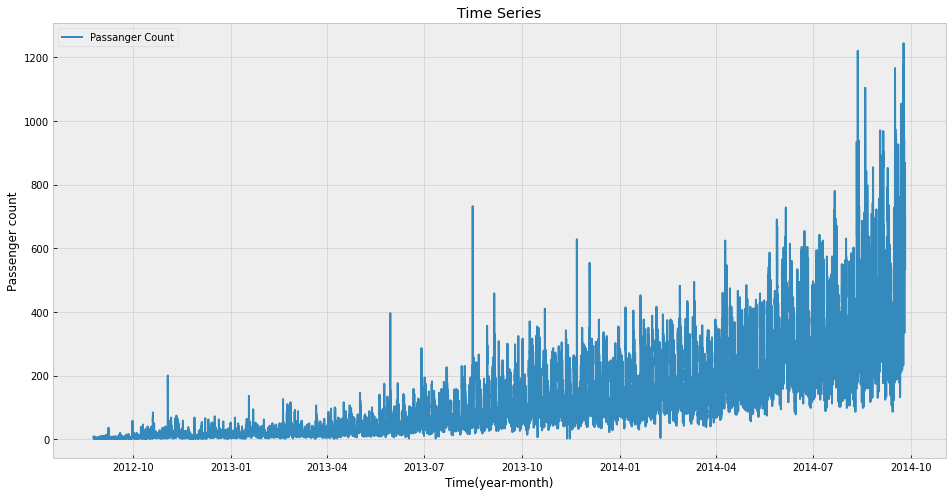

In [75]:
#view time series
train.index = train['Datetime']
#remove the id variable
trainN = train.drop('ID',1)

trainV = trainN['Count']
plt.figure(figsize = (16,8))
plt.plot(trainV, label ='Passanger Count')
plt.title('Time Series')
plt.xlabel('Time(year-month)')
plt.ylabel('Passenger count')
plt.legend(loc ='best')

### Exploratory Data Analysis

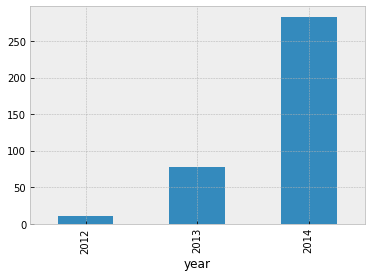

In [76]:
#Verify hypothesis 
train.groupby('year')['Count'].mean().plot.bar()

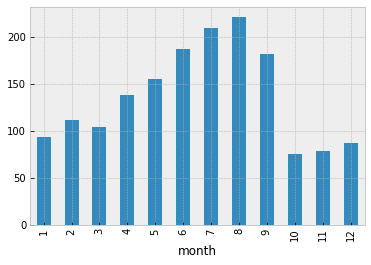

In [77]:
train.groupby('month')['Count'].mean().plot.bar()

This disproves out Hypothesis that during christmass the traffic is high

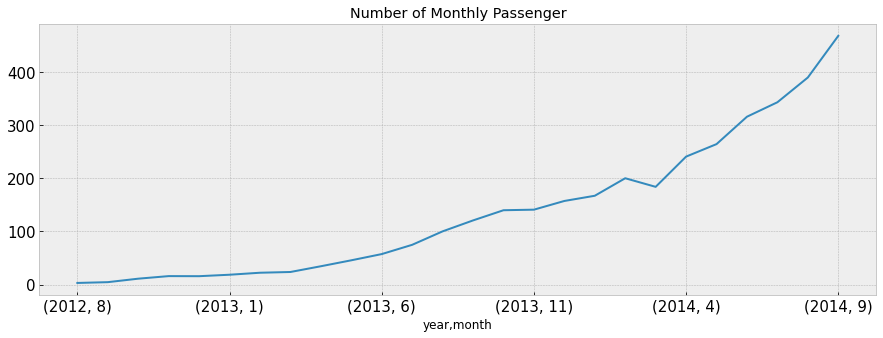

In [78]:
temp =train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize = (15, 5), title = 'Number of Monthly Passenger', fontsize =15)

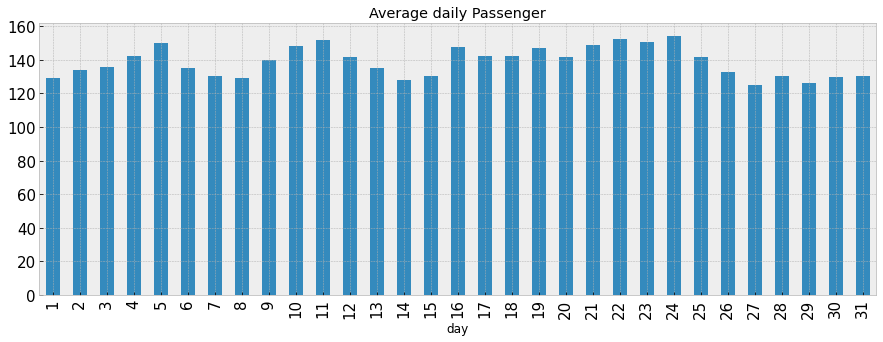

In [79]:
#observe the average dayily passenger in a month
train.groupby('day')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

Not much insight is gotton from the daily chart.
we go ahead to plot the monthly chart

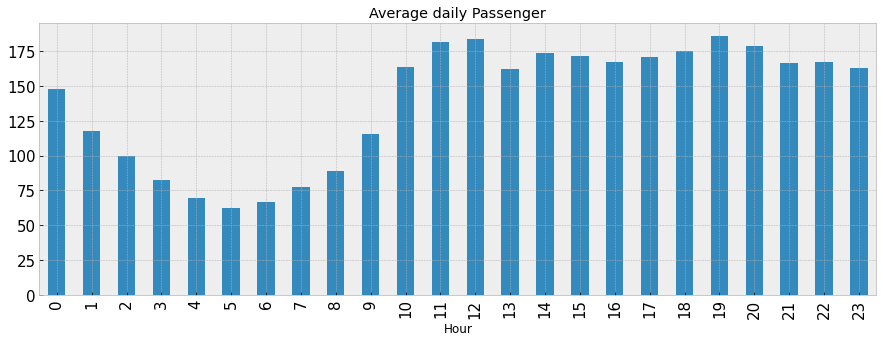

In [80]:
train.groupby('Hour')['Count'].mean().plot.bar(figsize = (15, 5), title = 'Average daily Passenger', fontsize =15)

### Note this provides a worthy insight unlike the daily average. the Hourly shows a peak  tile at 7pm. then a decline till Lowest at 5am. then stedy rise again. Points to note 
-7pm(19:00hrs) is the peak hour \
-5am is the les busiest hour \
-11 & 12PM are also busy hours 

Next to Validate another Hypothis which states that there will be more traffic in the week days compared to weekend

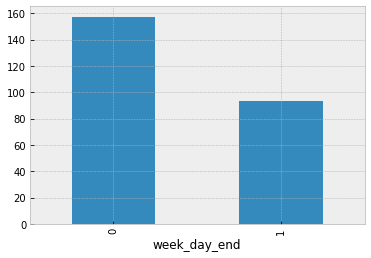

In [82]:
train.groupby('week_day_end')['Count'].mean().plot.bar()

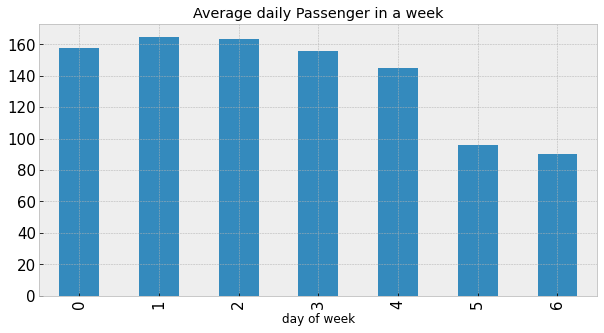

In [84]:
#average daily trafic in a week
train.groupby('day of week')['Count'].mean().plot.bar(figsize = (10, 5), title = 'Average daily Passenger in a week', fontsize =15)

The observation from this chart is that the hypothesis i correct. Customers are more on week days than week ends.

In [85]:
#drop the id column, it isn't necessary in this instance 
train =train.drop('ID',1)

In [87]:
train.Timestamp = pd.to_datetime(train.Datetime, format ='%d-%m-%Y %H:%M')
train.index =train.Timestamp

In [90]:
#hourly time series
hourly = train.resample('H').mean()
#convert to daily mean
daily = train.resample('D').mean()
#convert to weekly mean
weekly = train.resample('W').mean()
#convert to monthly mean
Monthly = train.resample('M').mean()

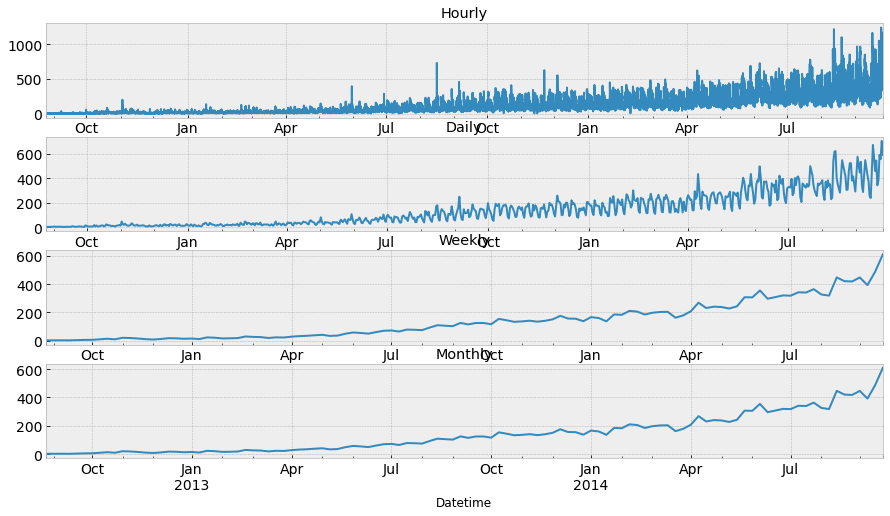

In [97]:
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize =(15,8), title ='Hourly', fontsize =14, ax =axs[0])
daily.Count.plot(figsize =(15,8), title ='Daily', fontsize =14, ax =axs[1])
weekly.Count.plot(figsize = (15,8), title ='Weekly', fontsize = 14, ax =axs[2])
weekly.Count.plot(figsize =(15,8), title ='Monthly', fontsize = 14, ax =axs[3])

plt.show()